<a href="https://colab.research.google.com/github/Linkanblomman/LSTM_occupancy_detection/blob/main/Raspberry_Pi_3_Occupancy_Detection_Dataset_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: Press the button "RESTART RUNTIME" if it appears and after that you can "run all". If you still get errors then repeat the process of pressing the  button "RESTART RUNTIME" and "run all" again.

In [ ]:
!pip install torch==1.0.0 torchvision==0.2.2

In [ ]:
!pip install tqdm

In [ ]:
!pip install -U pillow_simd==6.2.2.post1

In [ ]:
!pip install "pillow<7"
!pip install -U git+https://github.com/pytorch/vision

### Imports

In [5]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates

from tqdm import tqdm

import time

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [6]:
print(torch.__version__)

1.0.0


Customize the plot

In [7]:
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

Device configuration

In [ ]:
seed_value = 42
torch.manual_seed(seed_value)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla P100-PCIE-16GB


Load Occupancy Detection Dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
!unzip occupancy_data.zip
!rm occupancy_data.zip

In [12]:
!ls

datatest2.txt  datatest.txt  datatraining.txt  sample_data


In [13]:
raw_data_training_file = './datatraining.txt'

raw_data_test_file = './datatest.txt'
raw_data_test2_file = './datatest2.txt'

In [14]:
training_occupancy_dataframe = pd.read_csv(raw_data_training_file)

test_occupancy_dataframe = pd.read_csv(raw_data_test_file)
test2_occupancy_dataframe = pd.read_csv(raw_data_test2_file)

training_occupancy_df = pd.concat([training_occupancy_dataframe, test2_occupancy_dataframe], ignore_index=True) # Concat dataframe so that model won't overfit

In [15]:
def plot_signal(ax, x, y, title):
    ax.plot(x, y)
    if(title == "Temperature"):
      ax.set_title("Temperature")
      ax.set_ylabel("Temperature (°C)")
    elif(title == "Humidity"):
      ax.set_title("Humidity")
      ax.set_ylabel("Humidity (%)")
    elif(title == "Occupancy"):
      ax.set_title("Occupancy")
      ax.set_ylabel("Occupancy (0, 1)")
    elif(title == "LSTM"):
      ax.set_title("LSTM model prediction on test dataset")
      ax.set_ylabel("Occupancy (0, 1)")
    
    ax.set_xlabel("Observation")
    ax.set_xlim([min(x) , max(x)])

    start, end = ax.get_xlim()
    stepsize = 600
    ax.xaxis.set_ticks(np.arange(start, end + stepsize, stepsize))
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.grid(True)

In [16]:
def plt_dataFrame(dataFrame, features):
  subset_features = dataFrame[features]

  fig, axs = plt.subplots(nrows = len(subset_features.columns.values), figsize=(18, 18))
  for i in range(0, len(subset_features.columns.values)):
      plot_signal(axs[i], dataFrame.index, subset_features[subset_features.columns.values[i]],subset_features.columns.values[i])
  plt.subplots_adjust(hspace=0.5)
  plt.show()

In [17]:
features = ["Temperature", "Humidity", "Occupancy"]

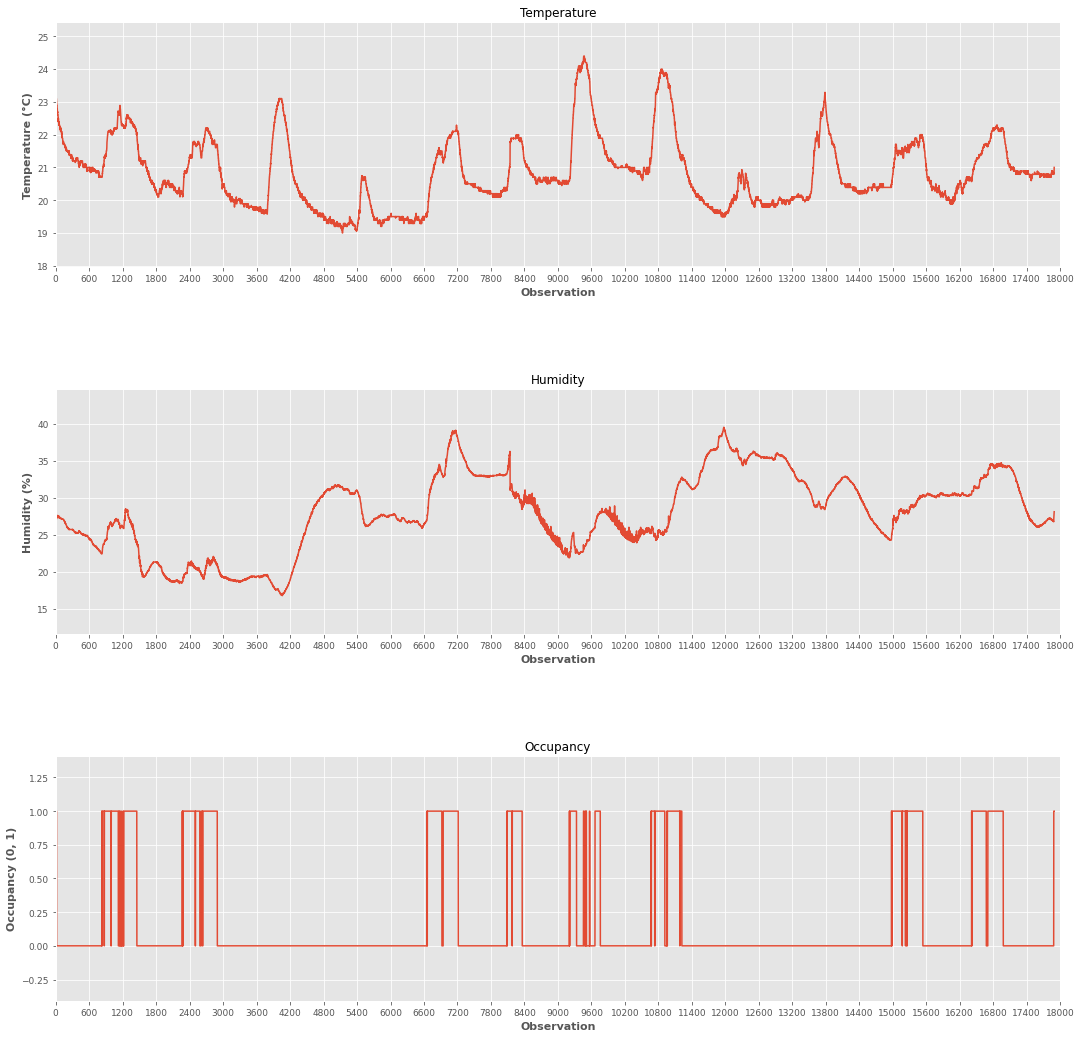

In [18]:
plt_dataFrame(training_occupancy_df, features)

In [20]:
def splitToFeaturesAndLabels(df, dataset):
  features = np.array(df[['Temperature', 'Humidity']])
  labels = np.array(df['Occupancy'].values)

  print(f"Total {dataset}_features for each feature: {len(features)}")
  print(f"Total {dataset}_labels: {len(labels)}")

  return features, labels

In [21]:
dataset_features, dataset_labels = splitToFeaturesAndLabels(training_occupancy_df, "dataset")
print("\n")
test_features, test_labels = splitToFeaturesAndLabels(test_occupancy_dataframe, "test")

Total dataset_features for each feature: 17895
Total dataset_labels: 17895


Total test_features for each feature: 2665
Total test_labels: 2665


In [22]:
scaler = StandardScaler() 
dataset_features = scaler.fit_transform(dataset_features)
test_features = scaler.fit_transform(test_features)

In [23]:
num_classes = 2 # Occupancy (0, 1)
batch_size = 32
learning_rate = 0.001

timestep = 20 # minutes

input_size = 2
hidden_size = 40 # hidden layers
num_layers = 1

validation_size = 0.10 # Validation dataset size

Set timestep. Credit to Sam Leach [link](https://github.com/samuelleach/lstm-sequence-to-label)

In [24]:
def timeSteps(X, Y, **options):   
    timestep = options.pop('timestep', None)
    _X, _Y = [], []
    for index in range(len(X) - timestep - 1):
      a = X[index:(index+timestep)]
      _X.append(a)
      _Y.append(Y[index + timestep])

    return np.array(_X), np.array(_Y)

In [25]:
X_train, Y_train = timeSteps(dataset_features, dataset_labels, timestep=timestep)
X_test, Y_test = timeSteps(test_features, test_labels, timestep=timestep)

Split dataset into training and validation datasets

In [26]:
(X_train, X_validation, Y_train, Y_validation) = train_test_split(X_train, Y_train, test_size=validation_size, random_state=seed_value, shuffle=False)

In [27]:
print(f"Training dataset size: {len(X_train)}")
print(f"Validation dataset size: {len(X_validation)}")

Training dataset size: 16086
Validation dataset size: 1788


PyTorch Dataset and DataLoader

In [28]:
class ToTensor:
  def __call__(self, batch):
    inputs, targets = batch
    return torch.tensor(inputs, dtype=torch.float).to(device), torch.tensor(targets, dtype=torch.int).to(device)

In [29]:
class OccDecDataset(Dataset):

  def __init__(self, x_features, y_features, transform=None):
    # Data loading
    self.x = x_features
    self.y = y_features
    self.n_samples = x_features.shape[0]
    self.transform = transform

  def __getitem__(self, index):
    batch = self.x[index], self.y[index] # [x , y]

    if self.transform:
      batch = self.transform(batch)
    else:
      print("Use transform ToTensor")

    return batch

  def __len__(self):
    # len(dataset)
    return self.n_samples

In [30]:
train_dataset = OccDecDataset(x_features=X_train, y_features=Y_train, transform=ToTensor())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

validation_dataset = OccDecDataset(x_features=X_validation, y_features=Y_validation, transform=ToTensor())
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = OccDecDataset(x_features=X_test, y_features=Y_test, transform=ToTensor())
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

LSTM model architecture

In [31]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_layer_size, num_classes): # num_classes == output_size
    super(RNN, self).__init__()
    self.hidden_layer_size = hidden_layer_size
    self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True) # input_seq has to be -> (batch_size, seq_length, input_size)
    self.fc = nn.Linear(hidden_layer_size, num_classes)

  def forward(self, input_seq):
    # Set initial hidden states and cell states
    h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)
    c0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)

    # "out" will give you access to all hidden states in the sequence
    # "hidden" will allow you to continue the sequence and backpropagate, by passing it as an argument to the lstm at a later time
    out, (h_out, _) = self.lstm(input_seq, (h0,c0)) # output of shape (seq_len, batch, num_directions * hidden_size)

    # flatten LSTM input for fully connected layer: (batch_size, hidden_size)
    h_out = h_out.view(-1, self.hidden_layer_size)
    out = self.fc(h_out)

    return out

In [32]:
model = RNN(input_size, hidden_size, num_classes).to(device)
model.to(device)
print(model)

RNN(
  (lstm): LSTM(2, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=2, bias=True)
)


Loss (CrossEntropyLoss) and optimizer (Adam optimization algorithm)

In [33]:
criterion = nn.CrossEntropyLoss() # Includes SoftMax and the prediction later will have raw values
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

Train the model

In [34]:
def fit(model, train_dataloader):
  print('Training')
  model.train()
  train_running_loss = 0.0
  train_running_correct = 0

  for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)): 
    features, labels = data[0].to(device), data[1].to(device)  

    labels = labels.type(torch.int64)
    features = features.to(device)
    
    optimizer.zero_grad()
    outputs = model(features) # input of shape (seq_len, batch, input_size)

    loss = criterion(outputs, labels)
    train_running_loss += loss.item()

    _, preds = torch.max(input=outputs.data, dim=1)
    train_running_correct += (preds == labels).sum().item()

    loss.backward()
    optimizer.step()
 
  train_loss = train_running_loss/len(train_dataloader.dataset)
  train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
  
  print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
  
  return train_loss, train_accuracy

Validate the model

In [35]:
def validate(model, validation_dataloader):
  print('Validating')
  model.eval()
  val_running_loss = 0.0
  val_running_correct = 0 
  with torch.no_grad():
    for i, data in tqdm(enumerate(validation_dataloader), total=int(len(validation_dataset)/validation_dataloader.batch_size)): 

      features, labels = data[0].to(device), data[1].to(device) 
      labels = labels.type(torch.int64)
      
      outputs = model(features)

      loss = criterion(outputs, labels)
      val_running_loss += loss.item()
      _, preds = torch.max(input=outputs.data, dim=1)
      val_running_correct += (preds == labels).sum().item()
      
    val_loss = val_running_loss/len(validation_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(validation_dataloader.dataset)
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')

  return val_loss, val_accuracy

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

epochs = 15
start = time.time()

for epoch in range(epochs):
  print(f"Epoch {epoch+1} of {epochs}")
  train_epoch_loss, train_epoch_accuracy = fit(model, train_dataloader)
  val_epoch_loss, val_epoch_accuracy = validate(model, validation_dataloader)


  train_loss.append(train_epoch_loss)
  train_accuracy.append(train_epoch_accuracy)
  val_loss.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

end = time.time()

print(f"{(end-start)/60:.2f} minutes")

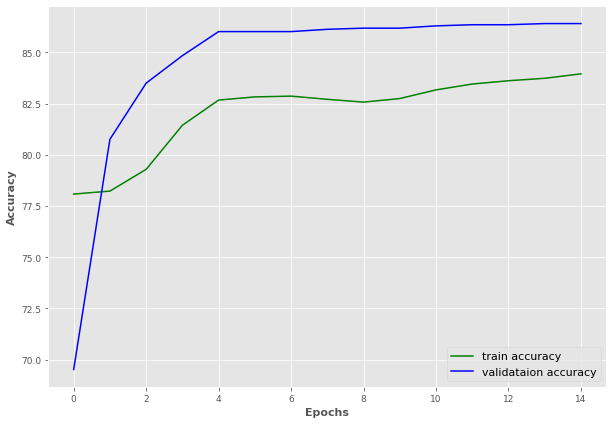

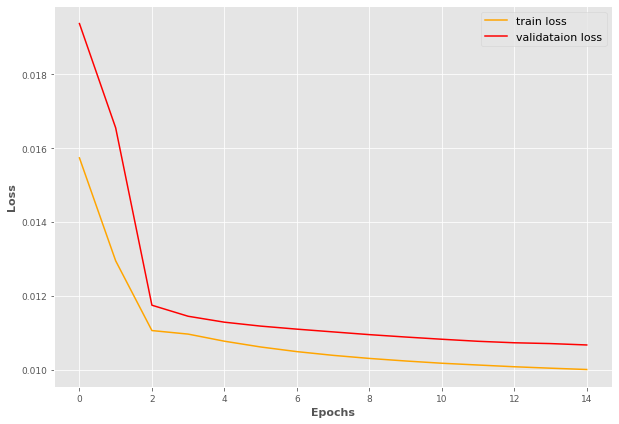

In [37]:
# Accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test the model

In [38]:
def evaluate(dataloader, dataset_size):
  pred_plt = []
  batch_size = 1

  model.eval()
  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset_size))):
      features, labels = data[0].to(device), data[1].to(device) 
      labels = labels.type(torch.int64).to(device)

      outputs = model(features)

      _, preds = torch.max(input=outputs.data, dim=1) # max returns (value ,index)
      pred_plt.append(preds.item())
      n_samples += labels.size(0)
      n_correct += (preds == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy on the Occupancy detection test dataset: {acc} %')

    return pred_plt

In [39]:
preds_test_plt = evaluate(test_dataloader, test_dataset)

100%|██████████| 2644/2644 [00:02<00:00, 1178.56it/s]

Accuracy on the Occupancy detection test dataset: 84.49319213313161 %


In [40]:
series_preds_test = np.hstack((np.zeros(timestep + 1, dtype=int), preds_test_plt))

In [41]:
test_occupancy_dataframe['LSTM'] = pd.Series(series_preds_test, index=test_occupancy_dataframe.index)

In [42]:
features = ['Temperature','Humidity', 'Occupancy','LSTM']

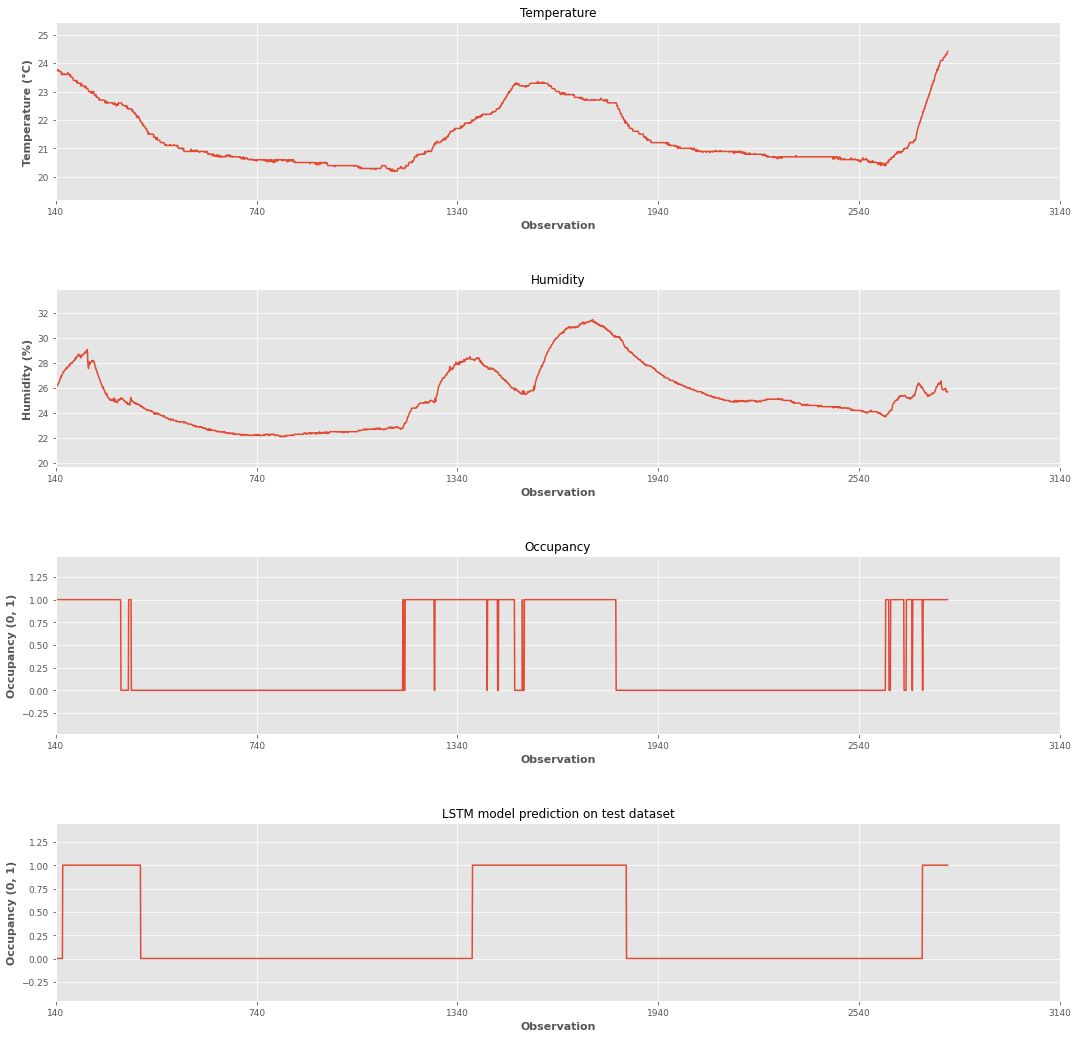

In [43]:
plt_dataFrame(test_occupancy_dataframe, features)

Save files for Raspberry Pi 3

In [45]:
PATH = "LSTM_model.pth"
torch.save(model.state_dict(), PATH) # Save model
torch.save(test_dataloader, 'dataloader.pth') # Save dataloader

In [46]:
!mkdir raspberry_pi_files

In [47]:
!mv LSTM_model.pth dataloader.pth datatest2.txt raspberry_pi_files

In [ ]:
!zip -r /content/raspberry_pi_files.zip ./raspberry_pi_files

In [49]:
from google.colab import files
files.download("/content/raspberry_pi_files.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>